In [13]:

# Parkinson's Disease Detection using Voice Data (UCI/Kaggle Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Input
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression


In [14]:
# 1. Load Dataset
df = pd.read_csv('/content/parkinsons.data')
df.drop(columns=['name'], inplace=True)

In [15]:
print("Shape of Dataset:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nClass Distribution:\n", df["status"].value_counts())

Shape of Dataset: (195, 23)

Missing Values:
 MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

Class Distribution:
 status
1    147
0     48
Name: count, dtype: int64


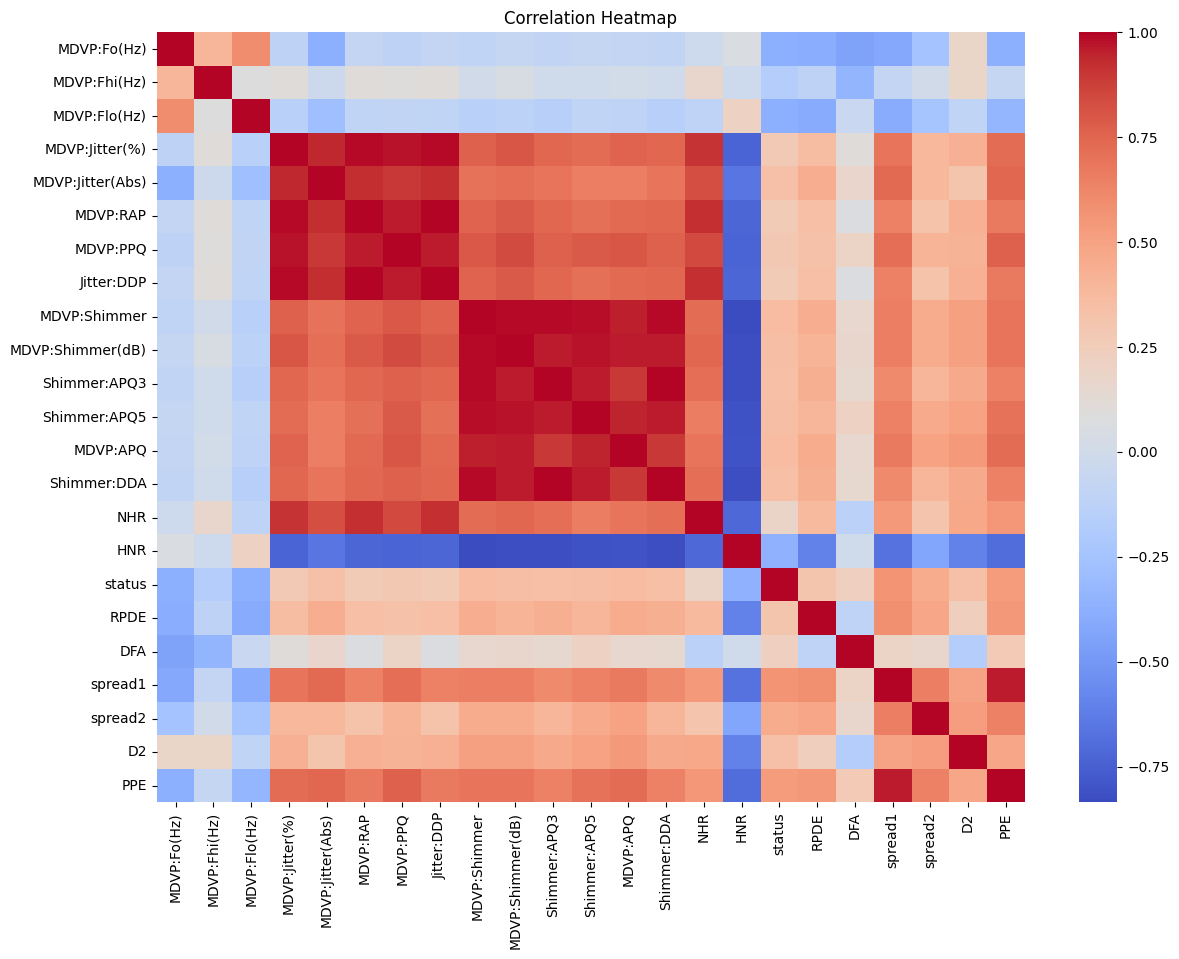

In [16]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()



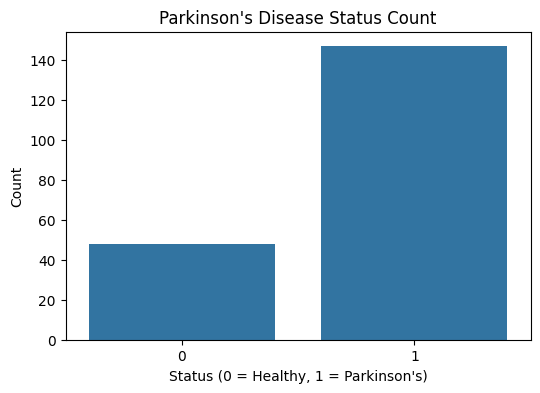

In [17]:
# 5. Class Balance Plot
plt.figure(figsize=(6, 4))
sns.countplot(x="status", data=df)
plt.title("Parkinson's Disease Status Count")
plt.xlabel("Status (0 = Healthy, 1 = Parkinson's)")
plt.ylabel("Count")
plt.show()

In [18]:
# 2. Preprocess
X = df.drop(columns=['status'])
y = df['status']
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [24]:
# 3. MLP Model
mlp = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=500, verbose=0)
mlp_pred = (mlp.predict(X_test) > 0.5).astype(int)
print("MLP Results\n", classification_report(y_test, mlp_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
MLP Results
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



In [20]:
# 4. LSTM Model
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
lstm = Sequential([
    LSTM(50, input_shape=(1, X_train.shape[1])),
    Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0)
lstm_pred = (lstm.predict(X_test_rnn) > 0.5).astype(int)
print("LSTM Results\n", classification_report(y_test, lstm_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
LSTM Results
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.87      0.93      0.90        29

    accuracy                           0.85        39
   macro avg       0.81      0.77      0.78        39
weighted avg       0.84      0.85      0.84        39



In [21]:
# 5. GRU Model
gru = Sequential([
    GRU(50, input_shape=(1, X_train.shape[1])),
    Dense(1, activation='sigmoid')
])
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_train_rnn, y_train, epochs=50, batch_size=32, verbose=0)
gru_pred = (gru.predict(X_test_rnn) > 0.5).astype(int)
print("GRU Results\n", classification_report(y_test, gru_pred))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
GRU Results
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.87      0.93      0.90        29

    accuracy                           0.85        39
   macro avg       0.81      0.77      0.78        39
weighted avg       0.84      0.85      0.84        39



In [22]:
# 6. Autoencoder + Logistic Regression
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, verbose=0)
encoder = Model(input_layer, encoded)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)
clf = LogisticRegression()
clf.fit(X_train_enc, y_train)
auto_pred = clf.predict(X_test_enc)
print("Autoencoder + Logistic Regression\n", classification_report(y_test, auto_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Autoencoder + Logistic Regression
               precision    recall  f1-score   support

           0       0.67      0.60      0.63        10
           1       0.87      0.90      0.88        29

    accuracy                           0.82        39
   macro avg       0.77      0.75      0.76        39
weighted avg       0.82      0.82      0.82        39



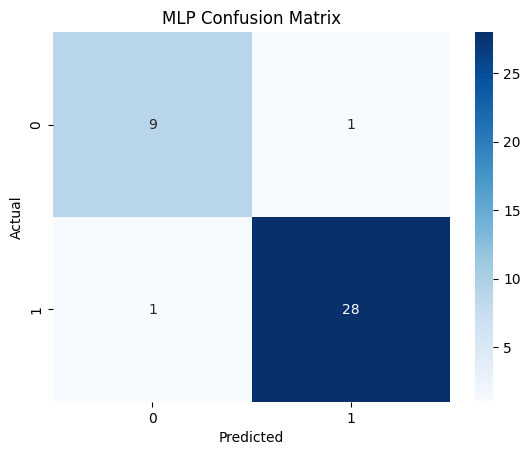

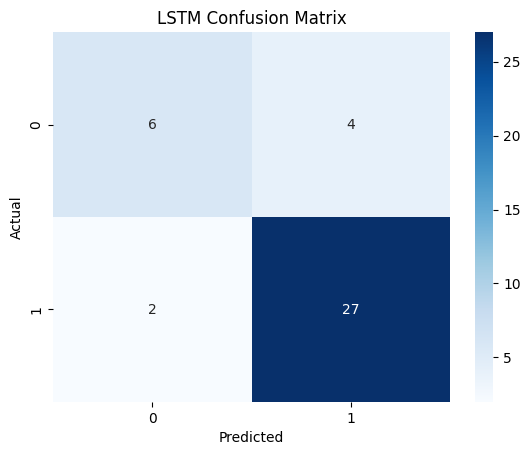

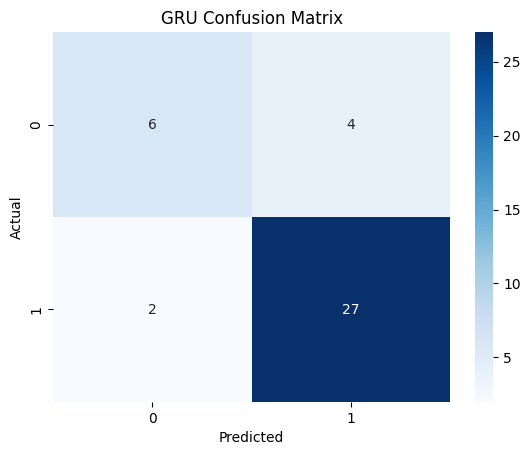

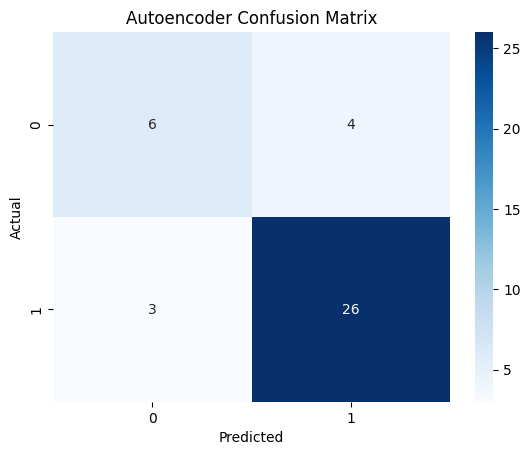

In [25]:
# 7. Visualization
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion(y_test, mlp_pred, "MLP Confusion Matrix")
plot_confusion(y_test, lstm_pred, "LSTM Confusion Matrix")
plot_confusion(y_test, gru_pred, "GRU Confusion Matrix")
plot_confusion(y_test, auto_pred, "Autoencoder Confusion Matrix")